Online Convolutional Dictionary Learning (CuPy Version)
=======================================================

This example demonstrates the use of [onlinecdl.OnlineConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.onlinecdl.html#sporco.dictlrn.onlinecdl.OnlineConvBPDNDictLearn) for learning a convolutional dictionary from a set of training images. The dictionary is learned using the online dictionary learning algorithm proposed in [[33]](http://sporco.rtfd.org/en/latest/zreferences.html#liu-2018-first). This variant of the example uses the GPU accelerated version of [onlinecdl](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.onlinecdl.html#module-sporco.dictlrn.onlinecdl) within the [sporco.cupy](http://sporco.rtfd.org/en/latest/modules/sporco.cupy.html#module-sporco.cupy) subpackage.

In [1]:
from __future__ import print_function
from builtins import input

import numpy as np

from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()
from sporco.cupy import (cupy_enabled, np2cp, cp2np, select_device_by_load,
                         gpu_info)
from sporco.cupy.dictlrn import onlinecdl

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.25)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S3 = exim.image('monarch.png', idxexp=np.s_[:, 160:672])
S4 = exim.image('sail.png', idxexp=np.s_[:, 210:722])
S5 = exim.image('tulips.png', idxexp=np.s_[:, 30:542])
S = np.stack((S1, S2, S3, S4, S5), axis=3)

Highpass filter training images.

In [3]:
npd = 16
fltlmbd = 5
sl, sh = signal.tikhonov_filter(S, fltlmbd, npd)

Construct initial dictionary.

In [4]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 3, 64)

Set regularization parameter and options for dictionary learning solver.

In [5]:
lmbda = 0.2
opt = onlinecdl.OnlineConvBPDNDictLearn.Options({
                'Verbose': True, 'ZeroMean': False, 'eta_a': 10.0,
                'eta_b': 20.0, 'DataType': np.float32,
                'CBPDN': {'rho': 5.0, 'AutoRho': {'Enabled': True},
                    'RelaxParam': 1.8, 'RelStopTol': 1e-7, 'MaxMainIter': 50,
                    'FastSolve': False, 'DataType': np.float32}})

Create solver object and solve.

In [6]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

d = onlinecdl.OnlineConvBPDNDictLearn(np2cp(D0), lmbda, opt)

iter = 50
d.display_start()
for it in range(iter):
    img_index = np.random.randint(0, sh.shape[-1])
    d.solve(np2cp(sh[..., [img_index]]))

d.display_end()
D1 = cp2np(d.getdict())
print("OnlineConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'))

Running on GPU 0 (GeForce RTX 2080 Ti)



Itn   X r       X s       X ρ       D cnstr   D dlt     D η     
----------------------------------------------------------------


   0  9.81e-04  1.58e-03  5.00e+00  8.03e+01  6.07e+00  5.00e-01


   1  1.82e-03  1.59e-03  5.00e+00  7.30e+01  4.64e+00  4.76e-01


   2  3.25e-03  2.01e-03  5.00e+00  2.38e+01  2.63e+00  4.55e-01


   3  1.91e-03  1.91e-03  5.00e+00  4.86e+01  2.31e+00  4.35e-01


   4  2.86e-03  1.80e-03  5.00e+00  2.00e+01  1.69e+00  4.17e-01


   5  1.87e-03  1.53e-03  5.00e+00  3.53e+01  1.98e+00  4.00e-01


   6  2.35e-03  3.19e-03  5.00e+00  3.60e+01  2.23e+00  3.85e-01


   7  1.69e-03  1.87e-03  5.00e+00  4.22e+01  2.15e+00  3.70e-01


   8  1.73e-03  1.51e-03  5.00e+00  3.19e+01  1.74e+00  3.57e-01


   9  2.01e-03  2.87e-03  5.00e+00  3.23e+01  1.86e+00  3.45e-01


  10  2.31e-03  1.91e-03  5.00e+00  1.58e+01  1.47e+00  3.33e-01


  11  1.90e-03  2.79e-03  5.00e+00  2.98e+01  1.57e+00  3.23e-01


  12  2.17e-03  1.87e-03  5.00e+00  2.49e+01  1.85e+00  3.12e-01


  13  2.61e-03  2.11e-03  5.00e+00  1.38e+01  1.17e+00  3.03e-01


  14  1.96e-03  2.23e-03  5.00e+00  3.45e+01  1.92e+00  2.94e-01


  15  2.37e-03  1.98e-03  5.00e+00  1.33e+01  1.03e+00  2.86e-01


  16  2.35e-03  2.16e-03  5.00e+00  2.16e+01  1.46e+00  2.78e-01


  17  2.27e-03  3.43e-03  5.00e+00  2.64e+01  1.82e+00  2.70e-01


  18  2.29e-03  2.04e-03  5.00e+00  1.25e+01  1.02e+00  2.63e-01


  19  1.92e-03  2.32e-03  5.00e+00  2.98e+01  1.54e+00  2.56e-01


  20  2.23e-03  2.11e-03  5.00e+00  1.95e+01  1.40e+00  2.50e-01


  21  2.18e-03  1.90e-03  5.00e+00  2.13e+01  1.24e+00  2.44e-01


  22  2.14e-03  3.30e-03  5.00e+00  2.33e+01  1.49e+00  2.38e-01


  23  1.85e-03  2.24e-03  5.00e+00  2.75e+01  1.41e+00  2.33e-01


  24  2.13e-03  1.98e-03  5.00e+00  1.78e+01  1.18e+00  2.27e-01


  25  2.10e-03  1.89e-03  5.00e+00  1.99e+01  1.14e+00  2.22e-01


  26  1.83e-03  2.28e-03  5.00e+00  2.58e+01  1.26e+00  2.17e-01


  27  1.70e-03  2.18e-03  5.00e+00  2.48e+01  8.44e-01  2.13e-01


  28  1.68e-03  2.22e-03  5.00e+00  2.44e+01  6.93e-01  2.08e-01


  29  2.16e-03  1.96e-03  5.00e+00  1.59e+01  1.21e+00  2.04e-01


  30  1.77e-03  2.36e-03  5.00e+00  2.40e+01  8.80e-01  2.00e-01


  31  1.92e-03  1.67e-03  5.00e+00  1.75e+01  1.15e+00  1.96e-01


  32  1.75e-03  1.60e-03  5.00e+00  1.76e+01  8.28e-01  1.92e-01


  33  2.10e-03  1.94e-03  5.00e+00  1.48e+01  1.00e+00  1.89e-01


  34  1.74e-03  2.23e-03  5.00e+00  2.26e+01  1.18e+00  1.85e-01


  35  2.12e-03  2.02e-03  5.00e+00  1.43e+01  8.84e-01  1.82e-01


  36  1.72e-03  2.25e-03  5.00e+00  2.16e+01  8.68e-01  1.79e-01


  37  2.15e-03  2.10e-03  5.00e+00  1.39e+01  7.84e-01  1.75e-01


  38  2.04e-03  1.82e-03  5.00e+00  1.57e+01  9.79e-01  1.72e-01


  39  1.70e-03  2.23e-03  5.00e+00  2.08e+01  1.00e+00  1.69e-01


  40  2.27e-03  3.35e-03  5.00e+00  1.62e+01  1.47e+00  1.67e-01


  41  2.03e-03  3.22e-03  5.00e+00  1.58e+01  1.04e+00  1.64e-01


  42  1.85e-03  3.02e-03  5.00e+00  1.58e+01  9.14e-01  1.61e-01


  43  1.68e-03  2.84e-03  5.00e+00  1.58e+01  9.14e-01  1.59e-01


  44  1.97e-03  1.74e-03  5.00e+00  1.38e+01  9.08e-01  1.56e-01


  45  2.12e-03  1.96e-03  5.00e+00  1.21e+01  9.53e-01  1.54e-01


  46  1.86e-03  3.08e-03  5.00e+00  1.57e+01  1.02e+00  1.52e-01


  47  1.82e-03  2.28e-03  5.00e+00  1.83e+01  1.24e+00  1.49e-01


  48  1.60e-03  2.72e-03  5.00e+00  1.52e+01  9.08e-01  1.47e-01


  49  2.05e-03  1.96e-03  5.00e+00  1.14e+01  8.44e-01  1.45e-01
----------------------------------------------------------------
OnlineConvBPDNDictLearn solve time: 20.60s


Display initial and final dictionaries.

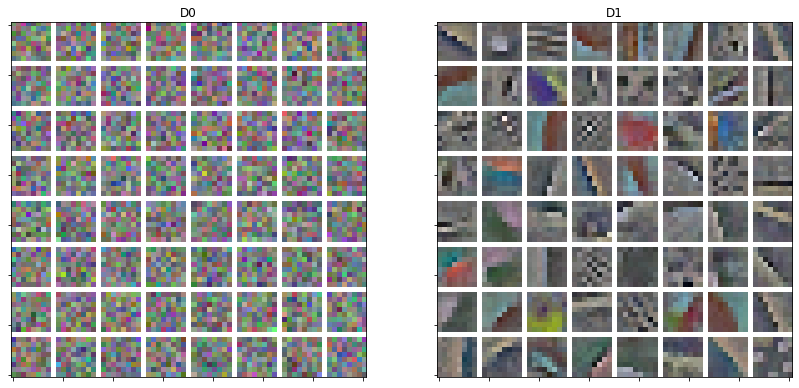

In [7]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0), title='D0', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1), title='D1', fig=fig)
fig.show()

Get iterations statistics from solver object and plot functional value.

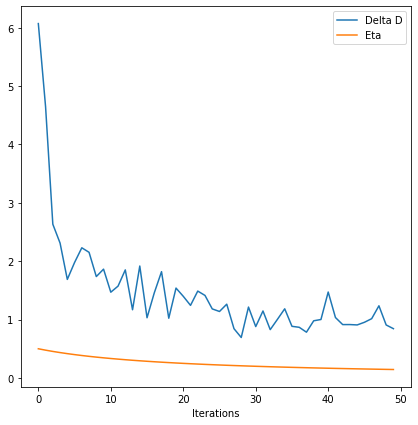

In [8]:
its = d.getitstat()
fig = plot.figure(figsize=(7, 7))
plot.plot(np.vstack((its.DeltaD, its.Eta)).T, xlbl='Iterations',
          lgnd=('Delta D', 'Eta'), fig=fig)
fig.show()